## SVM Notebook

In [1]:
!pip install -U libsvm-official
!pip install -U matplotlib # Install the newest version of matplotlib (requires kernel to be restarted)

import pandas as pd
import missingno as msno
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io as io
import libsvm
from libsvm.svmutil import *

from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset



In [51]:
Coupon_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
Coupon_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

# # Plotting distribution of examples across Coffeehouse feature 
# new_df = pd.value_counts(Coupon_train['Coffeehouse'], normalize=True).to_numpy()
# fig, ax = plt.subplots()
# bars = plt.bar([0,1,2,3,4], new_df, color='orange')
# ax.bar_label(bars, fmt='%.2f')
# ax.set_ylim(top=0.3)  # adjust xlim to fit labels

# # Quantifying missing values in training data set and test data set
# fig,axes = plt.subplots(nrows=1, ncols=2);
# fig.set_size_inches(20, 30); fig.set_dpi(100);
# ax = plt.subplot(1,2,1);
# msno.bar(Coupon_train, color='red')
# ax = plt.subplot(1,2,2);
# msno.bar(Coupon_test, color='blue')

### Data Imputation

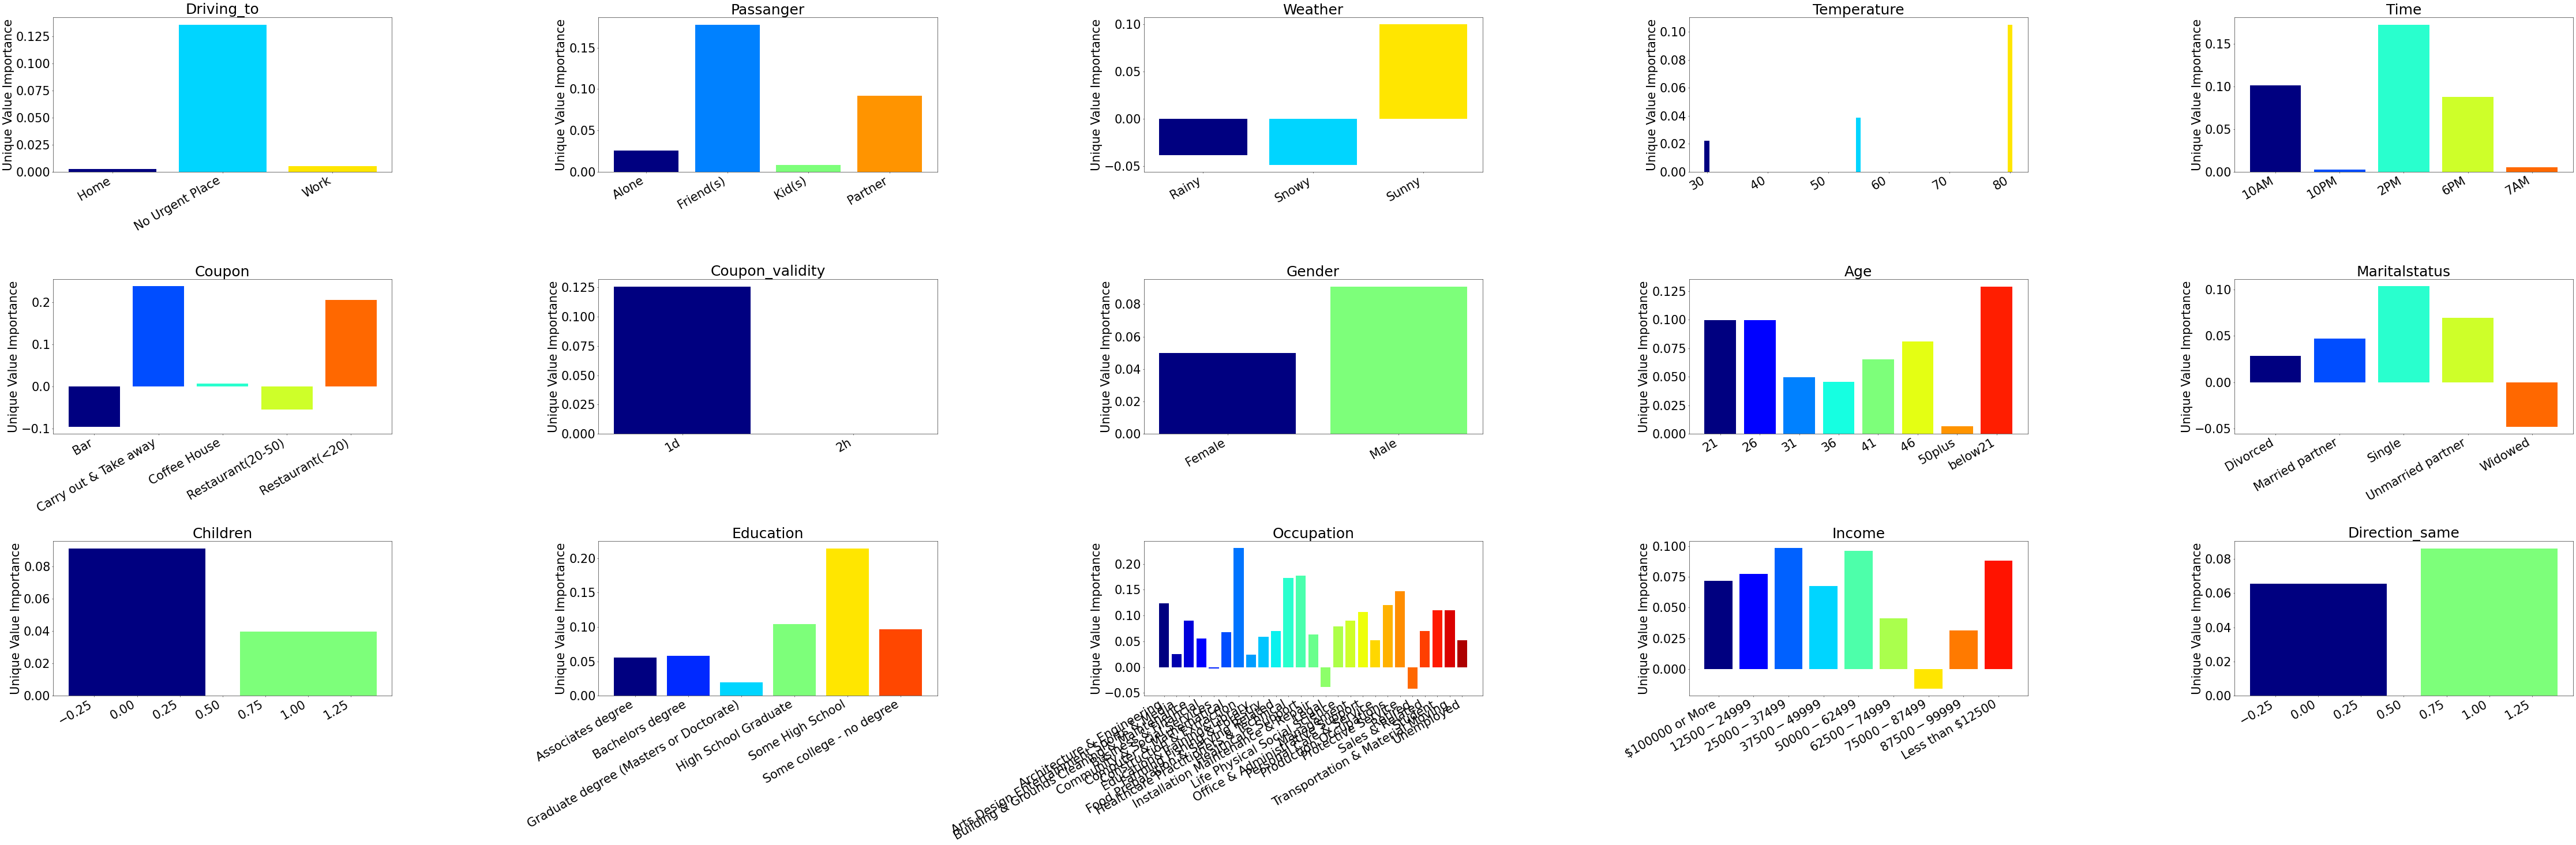

In [52]:
# Fill NaN values according to feature distribution
for col in Coupon_train:
  s = Coupon_train[col].value_counts(normalize=True)
  missing = Coupon_train[col].isnull()
  Coupon_train.loc[missing,col] = np.random.choice(s.index, size=len(Coupon_train[missing]),p=s.values)

# Fill NaN values according to feature distribution
for col in Coupon_test:
  s = Coupon_test[col].value_counts(normalize=True)
  missing = Coupon_test[col].isnull()
  Coupon_test.loc[missing,col] = np.random.choice(s.index, size=len(Coupon_test[missing]),p=s.values)

# Nominal Features, Ordinal Features + Frequency Subset
nominal = ['Driving_to','Passanger','Weather','Temperature','Time','Coupon','Coupon_validity','Gender',
           'Age','Maritalstatus','Children','Education','Occupation','Income','Direction_same']
ordinal = ['Bar','Coffeehouse','Carryaway','Restaurantlessthan20','Restaurant20to50','Distance']
frequency = ['Bar','Coffeehouse','Carryaway','Restaurantlessthan20','Restaurant20to50']

# Plotting "Unique Value Importance" for Nominal Features
UVI = {}
plt.rcParams.update({'font.size': 30})
fig, axes = plt.subplots(nrows=3, ncols=5); fig.set_size_inches(90, 30); fig.set_dpi(50);
for idx, col in enumerate(Coupon_train[nominal]):
  ax = plt.subplot(3,5,idx+1); ax.set_title(col);
  plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
  plt.ylabel('Unique Value Importance')
  new_frame = Coupon_train[[col, 'Decision']].groupby([col], as_index=False).mean()

  for i in range(0,len(new_frame[col])):
    importance = new_frame['Decision'][i] - 0.5
    UVI[str(col) + '_' + str(new_frame[col][i])] = importance
    plt.bar(new_frame[col][i], importance, color=cm.jet(1.*i/len(new_frame[col])))

fig.tight_layout(); plt.show();

# Removing id and Decision from train data
Coupon_train.drop('id', inplace=True, axis=1) # Removing id (redundant)
Decision = Coupon_train['Decision']
Coupon_train.drop('Decision', inplace=True, axis=1)

# Removing id from test data
id = Coupon_test['id'].to_numpy()
Coupon_test.drop('id', inplace=True, axis=1) # Removing id (redundant)

### Label Encoding Ordinal Features

In [5]:
# Training Data
Coupon_train[frequency] = Coupon_train[frequency].astype(int)
Coupon_train['Distance'] = Coupon_train['Distance'].map({1:0, 2:1, 3:0})
# Coupon_train['Temperature'] = Coupon_train['Temperature'].map({30:0, 55:0, 80:1})
# Coupon_train['Time'] = Coupon_train['Time'].map({"7AM":0, "10AM":1, "2PM":1, "6PM":1, "10PM":0})
# Coupon_train['Coupon_validity'] = Coupon_train['Coupon_validity'].map({"2h":1, "1d":0})
# Coupon_train['Age'] = Coupon_train['Age'].map({"below21":0, "21":0, "26":0, "31":1, "36":1, "41":1, "46":1, "50plus":1})
# Coupon_train['Income'] = Coupon_train['Income'].map({"Less than $12500":0, "$12500 - $24999":0, "$25000 - $37499":0, "$37500 - $49999":0,"$50000 - $62499":0, "$62500 - $74999":1, "$75000 - $87499":1, "$87500 - $99999":1, "$100000 or More":1})

# Test Data
Coupon_test[frequency] = Coupon_test[frequency].astype(int)
Coupon_test['Distance'] = Coupon_test['Distance'].map({1:0, 2:1, 3:2})
# Coupon_test['Temperature'] = Coupon_test['Temperature'].map({30:0, 55:1, 80:2})
# Coupon_test['Time'] = Coupon_test['Time'].map({"7AM":0, "10AM":1, "2PM":2, "6PM":3, "10PM":4})
# Coupon_test['Coupon_validity'] = Coupon_test['Coupon_validity'].map({"2h":1, "1d":0})
# Coupon_test['Age'] = Coupon_test['Age'].map({"below21":0, "21":1, "26":2, "31":3, "36":4, "41":5, "46":6, "50plus":7})
# Coupon_test['Income'] = Coupon_test['Income'].map({"Less than $12500":0, "$12500 - $24999":1, "$25000 - $37499":2, "$37500 - $49999":3,"$50000 - $62499":4, "$62500 - $74999":5, "$75000 - $87499":6, "$87500 - $99999":7, "$100000 or More":8})

### One-Hot Encoding Nominal Features

In [6]:
one_hot = OneHotEncoder(sparse=False)

# Training Data
Coupon_train_nominal = pd.DataFrame(one_hot.fit_transform(Coupon_train[nominal]), 
                                    index = np.arange(0,len(Coupon_train[nominal])), 
                                    columns = one_hot.get_feature_names_out(Coupon_train[nominal].columns))
Coupon_train = pd.concat([Decision, Coupon_train[ordinal], Coupon_train_nominal], axis=1)
Coupon_train = Coupon_train.astype(int) # Converting all training labels to int
Coupon_train.drop_duplicates(keep='first', inplace=True) # Drop duplicate labels

# Test Data
Coupon_test_nominal = pd.DataFrame(one_hot.fit_transform(Coupon_test[nominal]), 
                                   index = np.arange(0,len(Coupon_test[nominal])), 
                                   columns = one_hot.get_feature_names_out(Coupon_test[nominal].columns))
Coupon_test = pd.concat([Coupon_test[ordinal], Coupon_test_nominal], axis=1)
Coupon_test = Coupon_test.astype(int) # Converting all test labels to int

Coupon_train.to_csv('file.csv')
print(Coupon_train)
print(Coupon_test)

       Decision  Bar  ...  Direction_same_0  Direction_same_1
0             1    2  ...                 1                 0
1             0    0  ...                 1                 0
2             1    1  ...                 1                 0
3             1    2  ...                 1                 0
4             1    0  ...                 0                 1
...         ...  ...  ...               ...               ...
10179         0    1  ...                 1                 0
10180         1    1  ...                 1                 0
10181         0    3  ...                 1                 0
10182         0    2  ...                 1                 0
10183         0    1  ...                 1                 0

[10136 rows x 91 columns]
      Bar  Coffeehouse  ...  Direction_same_0  Direction_same_1
0       3            1  ...                 1                 0
1       0            3  ...                 0                 1
2       2            1  ...          

### Specifying Training and Test Data

In [7]:
X_train, y_train = Coupon_train.iloc[:, 1:].to_numpy(), Coupon_train.iloc[:, 0].to_numpy()
X_test = Coupon_test.iloc[:,:].to_numpy()
# LIBSVM Documentation: If labels of test data are unknown, simply use any random values.
y_test = np.ones(2500); y_test[:1250] = 0; np.random.shuffle(y_test)
print(X_train, '\n', X_test)

[[2 0 3 ... 0 1 0]
 [0 1 4 ... 0 1 0]
 [1 1 1 ... 0 1 0]
 ...
 [3 0 3 ... 0 1 0]
 [2 3 3 ... 0 1 0]
 [1 0 4 ... 0 1 0]] 
 [[3 1 2 ... 0 1 0]
 [0 3 3 ... 0 0 1]
 [2 1 2 ... 0 1 0]
 ...
 [2 3 4 ... 1 1 0]
 [1 2 3 ... 1 1 0]
 [2 1 3 ... 0 1 0]]


### **SVM (LIBSVM)**

#### Hyperparameter selection through k-fold cross validation

In [8]:
sigma_sq_range = np.arange(5,15,1)

K = 10 # 10-fold cross validation
kf = KFold(n_splits=K, random_state=None, shuffle=False)
train_accuracies = []
test_accuracies = []
num_SVs = np.zeros(len(sigma_sq_range))

for j, sigma_sq in enumerate(sigma_sq_range):
    print("Elapsed time: {}/{}".format(j, len(sigma_sq_range)))
    train_scores = np.zeros(K); test_scores = np.zeros(K); i = 0;

    # Splitting Training Data into 9 training folds and one test fold
    for train_index, test_index in kf.split(X_train):
        X_train_val, X_test_val = X_train[train_index], X_train[test_index]
        y_train_val, y_test_val = y_train[train_index], y_train[test_index]

        # Define the SVM problem
        problem = svm_problem(np.squeeze(y_train_val), X_train_val)
        # Define the hyperparameters
        # Note: gamma = 1/sigma^2
        param = svm_parameter()
        param.kernel_type = RBF
        param.gamma = 1/sigma_sq

        # Train the model
        model = svm_train(problem, param)
        support_vectors = X_train[np.array(model.get_sv_indices()) - 1]
        w = np.matmul(support_vectors.T, model.get_sv_coef())
        b = -model.rho.contents.value
        if model.get_labels()[1] == -1: w = -w; b = -b;
        slope = -w[0]/w[1]
        intercept = b
        
        # Make Predictions on the test fold and save accuracy
        train_labels, train_acc, train_vals = svm_predict(np.squeeze(y_train_val), X_train_val, model,'-q')
        test_labels, test_acc, test_vals = svm_predict(np.squeeze(y_test_val), X_test_val, model,'-q')
        train_scores[i] = train_acc[0]
        test_scores[i] = test_acc[0]
        num_SVs[j] = num_SVs[j] + len(support_vectors)
        i = i + 1

    # Average classification accuracy over folds
    train_accuracies.append(train_scores.mean())
    test_accuracies.append(test_scores.mean())
    num_SVs[j] = num_SVs[j]/K

Elapsed time: 5/10
Elapsed time: 6/10
Elapsed time: 7/10
Elapsed time: 8/10
Elapsed time: 9/10
Elapsed time: 10/10
Elapsed time: 11/10
Elapsed time: 12/10
Elapsed time: 13/10
Elapsed time: 14/10


Train Accuracies:
[95.75550090683723, 93.85687895768717, 92.00429365506173, 90.35670293030259, 88.95575746533831, 87.72252768162501, 86.63071209103252, 85.68468752573749, 84.81649532685687, 84.03600139130006]
Validation Accuracies:
[75.93720489650323, 76.11488519074517, 76.29242918976384, 76.29236104215222, 76.2232593639686, 76.18382136758626, 76.11478783701428, 75.99636675876329, 75.86815189518506, 75.71032202667101] 

Accuracy = 91.9495% (9320/10136) (classification)


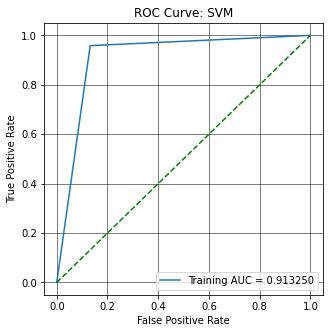

In [13]:
print('Train Accuracies:')
print(train_accuracies)
print('Validation Accuracies:')
print(test_accuracies,'\n')

# Plotting hyperparameters vs validation accuracy (recorded)
# plt.rcParams.update({'font.size': 20})
# fig, axes = plt.subplots(nrows=1, ncols=2); fig.set_size_inches(25, 10); fig.set_dpi(50);
# plt.subplot(1,2,1); plt.plot(sigma_sq_range, test_accuracies); plt.grid();
# plt.legend(['C-SVC with RBF kernel'])
# plt.xlabel('sigma_squared'); plt.ylabel('Validation Accuracy');
# plt.subplot(1,2,2); plt.plot(sigma_sq_range, num_SVs,color='r'); plt.grid();
# plt.legend(['C-SVC with RBF kernel'])
# plt.xlabel('sigma_squared'); plt.ylabel('Number of Support Vectors');

# Plotting ROC curve for training data set
problem = svm_problem(np.squeeze(y_train), X_train)
param = svm_parameter()
param.kernel_type = RBF
sigma_sq = sigma_sq_range[np.argmax(test_accuracies)]
param.gamma = 1/sigma_sq

model = svm_train(problem, param)
support_vectors = X_train[np.array(model.get_sv_indices()) - 1]
w = np.matmul(support_vectors.T, model.get_sv_coef())
b = -model.rho.contents.value
if model.get_labels()[1] == -1: w = -w; b = -b;
slope = -w[0]/w[1]; intercept = b;
y_train_pred,_,_ = svm_predict(np.squeeze(y_train), X_train, model)
train_fpr,train_tpr,_ = roc_curve(y_train, y_train_pred)

plt.rcParams.update({'font.size': 10}); plt.figure(figsize=(5,5));
plt.plot(train_fpr, train_tpr, label= "Training AUC = %f" %auc(train_fpr, train_tpr))
plt.plot([0,1],[0,1],'g--')
plt.legend(); plt.grid();
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: SVM")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

#### Infeasible to Visualize SVM Classifier


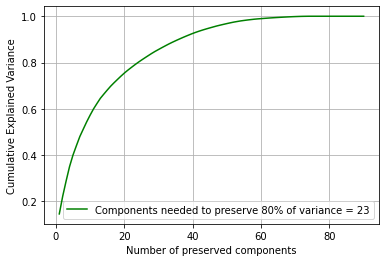

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=90).fit(X_train)
pca_nd = pca.transform(X_train)

variance_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(1,91),variance_explained,color='g'); plt.grid();
plt.xlabel('Number of preserved components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(['Components needed to preserve 80% of variance = {}'.format(np.argmax(variance_explained > 0.8))])

#### Test Set Prediction

In [10]:
# Define the SVM problem
problem = svm_problem(np.squeeze(y_train), X_train)

# Define the hyperparameters
# Note: gamma = 1/sigma^2
param = svm_parameter()
param.kernel_type = RBF
sigma_sq = sigma_sq_range[np.argmax(test_accuracies)]
print(sigma_sq)
param.gamma = 1/sigma_sq

# Train the model (fit optimal parameters to SVM model)
model = svm_train(problem, param)
support_vectors = X_train[np.array(model.get_sv_indices()) - 1]
w = np.matmul(support_vectors.T, model.get_sv_coef())
b = -model.rho.contents.value
if model.get_labels()[1] == -1: w = -w; b = -b;
slope = -w[0]/w[1]
intercept = b

# Obtain predictions on the test set
y_test_pred,_,_ = svm_predict(np.squeeze(y_test), X_test, model,'-q')

y_pred = [int(x) for x in y_test_pred]
print(y_pred)
import csv
from itertools import zip_longest
d = [id, y_pred]
export_data = zip_longest(*d, fillvalue = '')
with open('LIBSVM.csv', 'w', encoding="ISO-8859-1", newline='') as myfile:
      wr = csv.writer(myfile)
      wr.writerow(("id", "Decision"))
      wr.writerows(export_data)
myfile.close()

7
[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1